# 0. Set up libraries and download dataset

In [5]:
!pip install timm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 12.2 MB/s eta 0:00:00


In [6]:
import torch
import timm
from torch import nn
import os
from typing import Tuple, List
import glob
import json
import cv2
import numpy as np
from torch.utils.data import Dataset, DataLoader, random_split
from functools import partial
import torchvision.transforms as tf
import matplotlib.pyplot as plt
from timm.models.vision_transformer import _cfg, PatchEmbed
from timm.models.layers import trunc_normal_, DropPath
from google.colab.patches import cv2_imshow

os.environ['KMP_DUPLICATE_LIB_OK']='True'
get_ipython().__class__.__name__ = "ZMQInteractiveShell"

print('Torch', torch.__version__, 'CUDA', torch.version.cuda)
if torch.cuda.is_available():
    print('Device:', torch.cuda.get_device_name(0))

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Using {} device'.format(device))

Torch 2.1.0+cu121 CUDA 12.1
Using cpu device


In [ ]:
!wget https://huggingface.co/datasets/cissedelocht/timingdiagrams/resolve/main/dataset2.zip

--2024-03-07 10:56:02--  https://huggingface.co/datasets/cissedelocht/timingdiagrams/resolve/main/dataset2.zip
Resolving huggingface.co (huggingface.co)... 13.35.7.38, 13.35.7.57, 13.35.7.5, ...
Connecting to huggingface.co (huggingface.co)|13.35.7.38|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://cdn-lfs-us-1.huggingface.co/repos/e5/b6/e5b62e2dcd157ff2b3dca5105599639fe67e207262936b7f41e9730ca6313739/25b21126888bc9b6dc6b51b59b2e6fe39ba40aa283ee5ab8079fe68f821684cf?response-content-disposition=attachment%3B+filename*%3DUTF-8%27%27dataset2.zip%3B+filename%3D%22dataset2.zip%22%3B&response-content-type=application%2Fzip&Expires=1710068163&Policy=eyJTdGF0ZW1lbnQiOlt7IkNvbmRpdGlvbiI6eyJEYXRlTGVzc1RoYW4iOnsiQVdTOkVwb2NoVGltZSI6MTcxMDA2ODE2M319LCJSZXNvdXJjZSI6Imh0dHBzOi8vY2RuLWxmcy11cy0xLmh1Z2dpbmdmYWNlLmNvL3JlcG9zL2U1L2I2L2U1YjYyZTJkY2QxNTdmZjJiM2RjYTUxMDU1OTk2MzlmZTY3ZTIwNzI2MjkzNmI3ZjQxZTk3MzBjYTYzMTM3MzkvMjViMjExMjY4ODhiYzliNmRjNmI1MWI1OWIyZTZmZTM5Ym

In [ ]:
!unzip dataset2.zip

Streaming output truncated to the last 5000 lines.
 extracting: dataset2/ds_1285/beh_vlog_ff_pre_v8_3.v  
 extracting: dataset2/ds_1285/beh_vlog_ff_pre_v8_3_tb.v  
 extracting: dataset2/ds_1285/dump.vcd  
 extracting: dataset2/ds_1285/timer.json  
 extracting: dataset2/ds_1285/timingdiagram.png  
 extracting: dataset2/ds_12850/dump.vcd  
 extracting: dataset2/ds_12850/rtc.v  
 extracting: dataset2/ds_12850/rtc_tb.v  
 extracting: dataset2/ds_12850/timer.json  
 extracting: dataset2/ds_12850/timingdiagram.png  
 extracting: dataset2/ds_128506/dump.vcd  
 extracting: dataset2/ds_128506/fifo_generator_v13_1_0_axic_reg_slice.v  
 extracting: dataset2/ds_128506/fifo_generator_v13_1_0_axic_reg_slice_tb.v  
 extracting: dataset2/ds_128506/timer.json  
 extracting: dataset2/ds_128506/timingdiagram.png  
 extracting: dataset2/ds_128507/dump.vcd  
 extracting: dataset2/ds_128507/niosii_altpll_0_dffpipe_l2c.v  
 extracting: dataset2/ds_128507/niosii_altpll_0_dffpipe_l2c_tb.v  
 extracting: datase

# 1. Define training utility functions

In [7]:
def calculate_mean_std(images) -> Tuple[Tuple, Tuple]:
  converted_dataset = np.array(images) / 255
  mean = tuple(np.mean(converted_dataset, axis=(0,1)))
  std = tuple(np.std(converted_dataset, axis=(0,1)))

  return mean, std

def plot_losses(train_losses: List,
                test_losses: List,
                train_accuracies: List,
                test_accuracies: List,
                title: str):

  # Plot the Training History
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,5))
  fig.suptitle(title)
  ax1.plot(train_accuracies, label="Train")
  ax1.plot(test_accuracies, label="Test")
  ax1.set(xlabel='Epoch', ylabel='Accuracy')
  ax1.legend(loc="upper left")
  ax2.plot(train_losses, label='Train')
  ax2.plot(test_losses, label='Test')
  ax2.set(xlabel='Epoch', ylabel='Loss')
  ax2.legend(loc="upper right")

def train_loop(dataloader, model, loss_fn, optimizer, device):
  size = len(dataloader.dataset)
  num_batches = len(dataloader)
  train_loss = 0.0
  train_accuracy = 0.0
  for batch, (X, y) in enumerate(dataloader):
    # Compute prediction and loss
    out, pred = model(X.to(device))
    loss = loss_fn(pred, y.to(device))
    # Backpropagation
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    train_loss += loss.item()
    train_accuracy += (pred.argmax(1) == y.to(device)).type(torch.float).sum().item()


    if batch % 40 == 0:
      loss, current = loss.item(), batch * len(X)
      print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
      print()

  train_loss /= num_batches
  train_accuracy /= size
  return train_loss, train_accuracy


def test_loop(dataloader, model, loss_fn, device):
  size = len(dataloader.dataset)
  num_batches = len(dataloader)
  test_loss, test_accuracy = 0, 0

  with torch.no_grad():
    for X, y in dataloader:
      out, pred = model(X.to(device))
      test_loss += loss_fn(pred, y.to(device)).item()
      test_accuracy += (pred.argmax(1) == y.to(device)).type(torch.float).sum().item()

  test_loss /= num_batches
  test_accuracy /= size
  print(f"Test Error: \n Accuracy: {(100*test_accuracy):>0.1f}%, Avg loss: {test_loss:>8f} \n")
  return test_loss, test_accuracy


def start_training(epochs, train_loader, test_loader, model, loss_fn, optimizer, device):
  train_losses = []
  train_accuracies = []

  test_losses = []
  test_accuracies = []

  for t in range(epochs):
    print(f"Epoch {t + 1}\n-------------------------------")
    train_loss, train_acc = train_loop(train_loader,
                                       model,
                                       loss_fn,
                                       optimizer, device)

    test_loss, test_acc = test_loop(test_loader,
                                    model,
                                    loss_fn, device)

    train_losses.append(train_loss)
    train_accuracies.append(train_acc)

    test_losses.append(test_loss)
    test_accuracies.append(test_acc)

  if not os.path.exists("output_dir"):
        os.makedirs("output_dir")
  torch.save(model.state_dict(), os.path.join("output_dir", 'checkpoint_%02d.pth'%epochs))

  plot_losses(train_losses,
            test_losses,
            train_accuracies,
            test_accuracies,
            "ViT Classifier")

  print("Done!")

# 2. Create Dataset class
Running this cell shows the first four sample timing diagrams in the dataset. Please note that the images shown are already preprocessed to fit the dimensions of the transformer input (i.e. square images only).


PYDEV DEBUGGER WARNING:
sys.settrace() should not be used when the debugger is being used.
This may cause the debugger to stop working correctly.
If this is needed, please check: 
http://pydev.blogspot.com/2007/06/why-cant-pydev-debugger-work-with.html
to see how to restore the debug tracing back correctly.
Call Location:
  File "/usr/lib/python3.10/bdb.py", line 336, in set_trace
    sys.settrace(self.trace_dispatch)



> <ipython-input-8-90f566a28867>(40)__init__()
     38         std = tuple(value / self.length for value in self.mean_std[1])
     39         breakpoint()
---> 40         self.normalize = tf.Normalize(mean, std)
     41 
     42     def __len__(self):

ipdb> continue



PYDEV DEBUGGER WARNING:
sys.settrace() should not be used when the debugger is being used.
This may cause the debugger to stop working correctly.
If this is needed, please check: 
http://pydev.blogspot.com/2007/06/why-cant-pydev-debugger-work-with.html
to see how to restore the debug tracing back correctly.
Call Location:
  File "/usr/lib/python3.10/bdb.py", line 347, in set_continue
    sys.settrace(None)



0 torch.Size([3, 256, 256])
1 torch.Size([3, 256, 256])
2 torch.Size([3, 256, 256])
3 torch.Size([3, 256, 256])


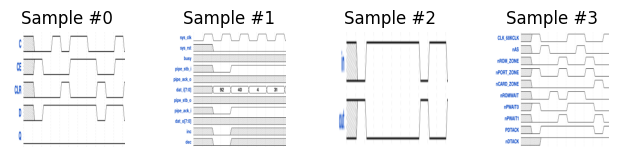

In [ ]:
class TD_dataset(Dataset):
    def __init__(self, im_size: int, dataset_path: str, sample: bool):
        self.folderpath = dataset_path
        file_list = glob.glob(self.folderpath + "*")
        #print(file_list)
        self.img_size = (im_size, im_size)
        self.sample = sample
        self.data = []
        self.length = 0
        self.mean_std = [(0,0,0) ,(0, 0, 0)]
        self.label_set = set()

        for class_path in file_list:

            json_name = glob.glob(class_path + "/timer.json")[0]
            with open(json_name, "r") as json_file:
                data = json.load(json_file)
            nr_of_signals = len(data.get("signal", []))

            if(nr_of_signals < 36):
                self.label_set.add(nr_of_signals)

                img_path = glob.glob(class_path + "/timingdiagram.png")[0]
                img = self.resize_image(img_path, self.img_size[0])

                mean, std = calculate_mean_std(img)
                self.mean_std[0] = tuple(map(sum, zip(self.mean_std[0], mean)))
                self.mean_std[1] = tuple(map(sum, zip(self.mean_std[1], std)))

                self.data.append([img_path, nr_of_signals])
                self.length += 1
                if(self.length % 200 == 0):
                    if(self.sample):
                      break
                    print("Looped over " + str(self.length) + " images")

        mean = tuple(value / self.length for value in self.mean_std[0])
        std = tuple(value / self.length for value in self.mean_std[1])
        breakpoint()
        self.normalize = tf.Normalize(mean, std)

    def __len__(self):
        return self.length

    def __getitem__(self, id):
        img_path, class_label = self.data[id]
        img = self.resize_image(img_path, self.img_size[0])
        img = img[..., ::-1] /255
        img_tensor = torch.from_numpy(img.copy())
        img_tensor = img_tensor.permute(2,1,0)
        if(self.sample==False):
          img_tensor = self.normalize(img_tensor.float())

        return img_tensor.float(), class_label

    def getNumClasses(self):
        return max(self.label_set)+1

    def resize_image(self, input_path, target_size):

        image = cv2.imread(input_path)
        left_cropped_image = image[:, :target_size*2]
        resized_image = cv2.resize(left_cropped_image, (target_size, target_size))

        return resized_image


im_size = 256
dataset = TD_dataset(im_size= im_size, dataset_path="dataset2/", sample=True)
data_loader = DataLoader(dataset, batch_size=32, shuffle=True)
fig = plt.figure()
num_classes = dataset.getNumClasses()

for i, data in enumerate(dataset):
    sample = data[0]
    print(i, sample.shape)
    sample = sample.permute(2, 1, 0) * 255
    sample = sample.int()
    ax = plt.subplot(1, 4, i + 1)
    plt.tight_layout()
    ax.set_title('Sample #{}'.format(i))
    ax.axis('off')
    plt.imshow(sample, cmap="gray")
    if i == 3:
        plt.show()
        break

# 3. ViT - Classifier Code

In [8]:
class Mlp(nn.Module):
    """ MLP as used in Vision Transformer, MLP-Mixer and related networks
    """

    def __init__(self, in_features, hidden_features=None, out_features=None, act_layer=nn.GELU, drop=0.):
        super().__init__()
        out_features = out_features or in_features
        hidden_features = hidden_features or in_features
        self.fc1 = nn.Linear(in_features, hidden_features)
        self.act = act_layer()
        self.fc2 = nn.Linear(hidden_features, out_features)
        self.drop = nn.Dropout(drop)

    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        x = self.drop(x)
        x = self.fc2(x)
        x = self.drop(x)
        return x


class Attention(nn.Module):
    def __init__(self, dim, num_heads=8, qkv_bias=False, qk_scale=None, attn_drop=0., proj_drop=0.):
        super().__init__()
        self.num_heads = num_heads
        head_dim = dim // num_heads
        # NOTE scale factor was wrong in my original version, can set manually to be compat with prev weights
        self.scale = qk_scale or head_dim ** -0.5
        self.qkv = nn.Linear(dim, dim * 3, bias=qkv_bias)
        self.attn_drop = nn.Dropout(attn_drop)
        self.proj = nn.Linear(dim, dim)
        self.proj_drop = nn.Dropout(proj_drop)
        self.attn_gradients = None
        self.attention_map = None

    def save_attn_gradients(self, attn_gradients):
        self.attn_gradients = attn_gradients

    def get_attn_gradients(self):
        return self.attn_gradients

    def save_attention_map(self, attention_map):
        self.attention_map = attention_map

    def get_attention_map(self):
        return self.attention_map

    def forward(self, x, register_hook=False):
        B, N, C = x.shape
        qkv = self.qkv(x).reshape(B, N, 3, self.num_heads, C // self.num_heads).permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]  # make torchscript happy (cannot use tensor as tuple)

        attn = (q @ k.transpose(-2, -1)) * self.scale
        attn = attn.softmax(dim=-1)
        attn = self.attn_drop(attn)

        if register_hook:
            self.save_attention_map(attn)
            attn.register_hook(self.save_attn_gradients)

        x = (attn @ v).transpose(1, 2).reshape(B, N, C)
        x = self.proj(x)
        x = self.proj_drop(x)
        return x


class Block(nn.Module):

    def __init__(self, dim, num_heads, mlp_ratio=4., qkv_bias=False, qk_scale=None, drop=0., attn_drop=0.,
                 drop_path=0., act_layer=nn.GELU, norm_layer=nn.LayerNorm):
        super().__init__()
        self.norm1 = norm_layer(dim)
        self.attn = Attention(
            dim, num_heads=num_heads, qkv_bias=qkv_bias, qk_scale=qk_scale, attn_drop=attn_drop, proj_drop=drop)
        # NOTE: drop path for stochastic depth, we shall see if this is better than dropout here
        self.drop_path = DropPath(drop_path) if drop_path > 0. else nn.Identity()
        self.norm2 = norm_layer(dim)
        mlp_hidden_dim = int(dim * mlp_ratio)
        self.mlp = Mlp(in_features=dim, hidden_features=mlp_hidden_dim, act_layer=act_layer, drop=drop)

    def forward(self, x, register_hook=False):
        x = x + self.drop_path(self.attn(self.norm1(x), register_hook=register_hook))
        x = x + self.drop_path(self.mlp(self.norm2(x)))
        return x


class VisionTransformer(nn.Module):
    """ Vision Transformer
    A PyTorch impl of : `An Image is Worth 16x16 Words: Transformers for Image Recognition at Scale`  -
        https://arxiv.org/abs/2010.11929
    """

    def __init__(self, img_size=224, patch_size=16, in_chans=3, num_classes=1000, embed_dim=768, depth=12,
                 num_heads=12, mlp_ratio=4., qkv_bias=True, qk_scale=None, representation_size=None,
                 drop_rate=0., attn_drop_rate=0., drop_path_rate=0., norm_layer=None, inference=False):
        """
        Args:
            img_size (int, tuple): input image size
            patch_size (int, tuple): patch size
            in_chans (int): number of input channels
            num_classes (int): number of classes for classification head
            embed_dim (int): embedding dimension
            depth (int): depth of transformer
            num_heads (int): number of attention heads
            mlp_ratio (int): ratio of mlp hidden dim to embedding dim
            qkv_bias (bool): enable bias for qkv if True
            qk_scale (float): override default qk scale of head_dim ** -0.5 if set
            representation_size (Optional[int]): enable and set representation layer (pre-logits) to this value if set
            drop_rate (float): dropout rate
            attn_drop_rate (float): attention dropout rate
            drop_path_rate (float): stochastic depth rate
            norm_layer: (nn.Module): normalization layer
        """
        super().__init__()
        self.num_features = self.embed_dim = embed_dim  # num_features for consistency with other models
        norm_layer = norm_layer or partial(nn.LayerNorm, eps=1e-6)

        self.patch_embed = PatchEmbed(
            img_size=img_size, patch_size=patch_size, in_chans=in_chans, embed_dim=embed_dim)
        num_patches = self.patch_embed.num_patches

        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
        self.pos_embed = nn.Parameter(torch.zeros(1, num_patches + 1, embed_dim))
        self.pos_drop = nn.Dropout(p=drop_rate)

        dpr = [x.item() for x in torch.linspace(0, drop_path_rate, depth)]  # stochastic depth decay rule
        self.blocks = nn.ModuleList([
            Block(
                dim=embed_dim, num_heads=num_heads, mlp_ratio=mlp_ratio, qkv_bias=qkv_bias, qk_scale=qk_scale,
                drop=drop_rate, attn_drop=attn_drop_rate, drop_path=dpr[i], norm_layer=norm_layer)
            for i in range(depth)])
        self.norm = norm_layer(embed_dim)

        trunc_normal_(self.pos_embed, std=.02)
        trunc_normal_(self.cls_token, std=.02)
        self.apply(self._init_weights)

        self.classifier = nn.Linear(in_features=embed_dim, out_features=num_classes)
        self.inference = inference
    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            trunc_normal_(m.weight, std=.02)
            if isinstance(m, nn.Linear) and m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)

    @torch.jit.ignore
    def no_weight_decay(self):
        return {'pos_embed', 'cls_token'}

    def forward(self, x, register_blk=-1):
        B = x.shape[0]
        x = self.patch_embed(x)

        cls_tokens = self.cls_token.expand(B, -1, -1)  # stole cls_tokens impl from Phil Wang, thanks
        x = torch.cat((cls_tokens, x), dim=1)

        x = x + self.pos_embed[:, :x.size(1), :]
        x = self.pos_drop(x)

        for i, blk in enumerate(self.blocks):
            x = blk(x, register_blk == i)
        x = self.norm(x)
        pred = self.classifier(x[:, 0])             #Only use class token for classification
        if(self.inference):
            pred = nn.functional.softmax(pred, dim=1)
        return x, pred


def interpolate_pos_embed(pos_embed_checkpoint, visual_encoder):
    # interpolate position embedding
    embedding_size = pos_embed_checkpoint.shape[-1]
    num_patches = visual_encoder.patch_embed.num_patches
    num_extra_tokens = visual_encoder.pos_embed.shape[-2] - num_patches
    # height (== width) for the checkpoint position embedding
    orig_size = int((pos_embed_checkpoint.shape[-2] - num_extra_tokens) ** 0.5)
    # height (== width) for the new position embedding
    new_size = int(num_patches ** 0.5)

    if orig_size != new_size:
        # class_token and dist_token are kept unchanged
        extra_tokens = pos_embed_checkpoint[:, :num_extra_tokens]
        # only the position tokens are interpolated
        pos_tokens = pos_embed_checkpoint[:, num_extra_tokens:]
        pos_tokens = pos_tokens.reshape(-1, orig_size, orig_size, embedding_size).permute(0, 3, 1, 2)
        pos_tokens = torch.nn.functional.interpolate(
            pos_tokens, size=(new_size, new_size), mode='bicubic', align_corners=False)
        pos_tokens = pos_tokens.permute(0, 2, 3, 1).flatten(1, 2)
        new_pos_embed = torch.cat((extra_tokens, pos_tokens), dim=1)
        print('reshape position embedding from %d to %d' % (orig_size ** 2, new_size ** 2))

        return new_pos_embed
    else:
        return pos_embed_checkpoint

# 4. Main Training Code

When the model is done training the checkpoint is saved to an "output_dir".

In [ ]:
im_size = 256
dataset_path = "dataset2/"

dataset = TD_dataset(im_size=im_size, dataset_path=dataset_path, sample=False)
train_size = int(0.9 * len(dataset))
test_size = len(dataset) - train_size

# Split the dataset
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=True)
num_classes = dataset.getNumClasses()



ViT_Classifier = VisionTransformer(
        img_size=im_size, patch_size=16, embed_dim=512, depth=6, num_heads=8, num_classes=num_classes,
        mlp_ratio=4, qkv_bias=True,
        norm_layer=partial(nn.LayerNorm, eps=1e-6))  # embed_dim / num_heads should be integer

lr = 0.005
epochs = 15
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(ViT_Classifier.parameters(), lr=lr, weight_decay=0.001)

start_training(epochs, train_loader,test_loader, ViT_Classifier.to(device), loss_function, optimizer, device)

# 5. Inference with new images
The following code block loads the pretrained-model and tries to identify the number of signals in a newly provided timing diagram. Please note:

*   Upload images for testing manually and add their PATH names to the "image_paths" list
* Please upload the "checkpoint_15.pth" file manually from the hand-in and wait until upload is completed
*   The model was trained on a GPU, if your runtime does not provide a CUDA device it won't work

*   Timing diagrams generated by Wavedrom are identified with near 100% accuracy
*   Timing diagrams generated by other tools are poorly identified.

Poor performance with other timing diagrams is due to the fact that the whole dataset on which the model was trained was generated by Wavedrom.


In [14]:
def resize_image(input_path, target_size):
    image = cv2.imread(input_path)

    left_cropped_image = image[:, :target_size * 2]
    cv2_imshow(left_cropped_image)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

    resized_image = cv2.resize(left_cropped_image, (target_size, target_size))

    return resized_image

im_size = 256
num_classes = 36
device = 'cpu'
mean = tuple((0.9339429233425149, 0.9228434628923606, 0.9173283897871389))
std = tuple((0.16970819863355766, 0.18543849552237282, 0.1991479431864125))
normalize = tf.Normalize(mean, std)

model = VisionTransformer(
        img_size=im_size, patch_size=16, embed_dim=512, depth=6, num_heads=8, num_classes=num_classes,
        mlp_ratio=4, qkv_bias=True,
        norm_layer=partial(nn.LayerNorm, eps=1e-6))
model.load_state_dict(torch.load("checkpoint_15.pth"))
model.eval()
model.to(device)

image_paths = ["and_gate.png", "or_gate.png"]  #names of your image files
predictions = []

for img_path in image_paths:
    img = resize_image(img_path, im_size)
    img = img[..., ::-1] / 255
    img_tensor = torch.from_numpy(img.copy())
    img_tensor = img_tensor.permute(2, 1, 0)
    img_tensor = normalize(img_tensor.float())
    img_tensor = torch.unsqueeze(img_tensor, 0)
    with torch.no_grad():
        out, pred = model(img_tensor.to(device))
        probs = nn.functional.softmax(pred, dim=1)
        _, predicted_class = torch.max(probs, 1)
        predictions.append(predicted_class.item())
print(predictions)

RuntimeError: Attempting to deserialize object on a CUDA device but torch.cuda.is_available() is False. If you are running on a CPU-only machine, please use torch.load with map_location=torch.device('cpu') to map your storages to the CPU.